In [1]:
# Install the required packages
!pip install -r requirements.txt > /dev/null

In [2]:
from __future__ import annotations
import cv2
import copy
import torch
import einops
import mediapy
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from typing import Any
from typing import Callable
from dataclasses import dataclass
from diffusers.utils import load_image
from torch.nn import functional as nnf
from diffusers.models import attention_processor
from diffusers.image_processor import PipelineImageInput
from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers.utils.torch_utils import is_compiled_module, is_torch_version
from diffusers import StableDiffusionXLPipeline, DDIMScheduler, ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL

from src.Handler import Handler
from src.StyleAlignedArgs import StyleAlignedArgs
from src.Tokenization_and_Embedding import prompt_tokenizazion_and_embedding, embeddings_ensemble, embeddings_ensemble_with_neg_conditioning
from src.Encode_Image import image_encoding
from src.Diffusion import Generate_Noise_Prediction, Denoising_next_step, DDIM_Process, extract_latent_and_inversion, DDIM_Inversion_Process

# For the Blip model (Content Image).
import os
from transformers import BlipProcessor, BlipForConditionalGeneration

# For the Whisper model (Content Audio).
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import librosa

# For the Music Model (Content AudioMusic).
import hashlib
import torchaudio
# from laion_clap import CLAP_Module

# For the Summarization and rephrasing.
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Create Alias for torch.tensor to increase readability.
T = torch.tensor
TN = T

/home/khshim/anaconda3/envs/sa/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/home/khshim/anaconda3/envs/sa/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


#### Model Load

In [3]:
# Create a DDIMScheduler object with specific parameters
scheduler = DDIMScheduler(
    beta_start=0.00085,            # Starting value of beta for the noise schedule
    beta_end=0.012,                # Ending value of beta for the noise schedule
    beta_schedule="scaled_linear", # Type of beta schedule to use, here it is scaled linear
    clip_sample=False,             # Whether to clip the samples to a certain range
    set_alpha_to_one=False         # Whether to set alpha to one
)

# Load the Stable Diffusion XL Reference_Pipeline with a pretrained model
Reference_Pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  # Model name or path
    torch_dtype=torch.float16,                   # Data type for PyTorch tensors
    variant="fp16",                              # Variant of the model, here it is fp16 (16-bit floating point)
    use_safetensors=True,                        # Whether to use safe tensors
    scheduler=scheduler                          # Use the scheduler defined above
).to("cuda")                                     # Move the pipeline to the CUDA device (GPU)

/home/khshim/anaconda3/envs/sa/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [4]:
# 1) VanGogh Painting
# Set the source style, prompt and path.
# src_style = "Van Gogh round painting"
# src_prompt = f'The starry night, {src_style}.'
# reference_image_path = 'asset/img/original.jpg'

# 2) Cubism Painting
# src_style = "cubism painting"
# src_prompt = f'Two men smoking water pipe, {src_style}.'
# reference_image_path = 'asset/img/Picasso_Smoking_Water_Pipe.jpeg'


# 3) Kid Drawing
src_style = "Kid Drawing"
src_prompt = f'A city with two houses and a church, {src_style}.'
reference_image_path = 'asset/img/kid_drawing.jpeg'

# 4) Medieval Painting
# src_style = "Medieval Painting"
# src_prompt = f'Man laying in a bed, {src_style}.'
# reference_image_path = 'asset/img/medieval-bed.jpeg'


# Setting the number of inference steps in the Diffusion Inversion Process.
num_inference_steps = 50

# Setting the Guidance Scale for the Diffusion Inversion Process.
guidance_scale = 10.0

# 1) Normal Painting
# These are some parameters you can Adjust to Control StyleAlignment to Reference Image.
#style_alignment_score_shift = np.log(2)  # higher value induces higher fidelity, set 0 for no shift
#style_alignment_score_scale = 1.0  # higher value induces higher, set 1 for no rescale

# 2) Very Famous Paintings
style_alignment_score_shift = np.log(1)
style_alignment_score_scale = 0.5


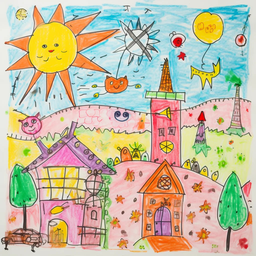

In [5]:
# Load the reference image and resize it to 1024x1024 pixels.
ref_image = np.array(load_image(reference_image_path).resize((1024, 1024)))

# Display the output image.
mediapy.show_image(ref_image, title="Reference Image for Style Alignment", height=256)

In [6]:
# Defining a type alias for the Diffusion Inversion Process type of callable.
Diff_Inversion_Process_Callback = Callable[[StableDiffusionXLPipeline, int, T, dict[str, T]], dict[str, T]]

### WEATHER DATA RETRIEVING

In [9]:
import requests

def get_weather_conditions(city):
    api_key = "5b55a97e9a4376978568ae7ad0e394f9"  # Replace with your OpenWeatherMap API key
    base_url = "http://api.openweathermap.org/data/2.5/weather?"
    complete_url = f"{base_url}q={city}&appid={api_key}&units=metric"

    response = requests.get(complete_url)
    data = response.json()
    print(data)

    if data["cod"] != "404":
        weather = data["weather"][0]["description"]
        return weather
    else:
        return "Weather data not found"

city = "Seoul"
weather_description = get_weather_conditions(city)
print(f"Current weather in {city}: {weather_description}")

{'coord': {'lon': 126.9778, 'lat': 37.5683}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'base': 'stations', 'main': {'temp': 2.76, 'feels_like': 2.76, 'temp_min': 2.76, 'temp_max': 3.66, 'pressure': 1030, 'humidity': 87, 'sea_level': 1030, 'grnd_level': 1023}, 'visibility': 10000, 'wind': {'speed': 1.03, 'deg': 350}, 'clouds': {'all': 0}, 'dt': 1732460176, 'sys': {'type': 1, 'id': 8105, 'country': 'KR', 'sunrise': 1732400483, 'sunset': 1732436192}, 'timezone': 32400, 'id': 1835848, 'name': 'Seoul', 'cod': 200}
Current weather in Seoul: clear sky


In [10]:
# Set of prompts to generate images for. The first refers to the Reference Image. The other to generate images.
prompts = [
    src_prompt,  # Reference Image Prompt
    weather_description + " weather"
    # *paraphrased_descriptions  # Prompts extracted from Img+Music
]
print(prompts)

# Append the reference style to each of subsequent prompts for generating images with the same Style.
for i in range(1, len(prompts)):
    prompts[i] = f'{prompts[i]}, {src_style}.'

# Configure the StyleAligned Handler using the StyleAlignedArgs.
handler = Handler(Reference_Pipeline)
sa_args = StyleAlignedArgs(
    share_group_norm=True,
    share_layer_norm=True,
    share_attention=True,
    adain_queries=True,
    adain_keys=True,
    adain_values=False,
    style_alignment_score_shift=style_alignment_score_shift,
    style_alignment_score_scale=style_alignment_score_scale)
handler.register(sa_args)

['A city with two houses and a church, Kid Drawing.', 'clear sky weather']


100%|██████████| 50/50 [00:17<00:00,  2.85it/s]


  0%|          | 0/50 [00:00<?, ?it/s]


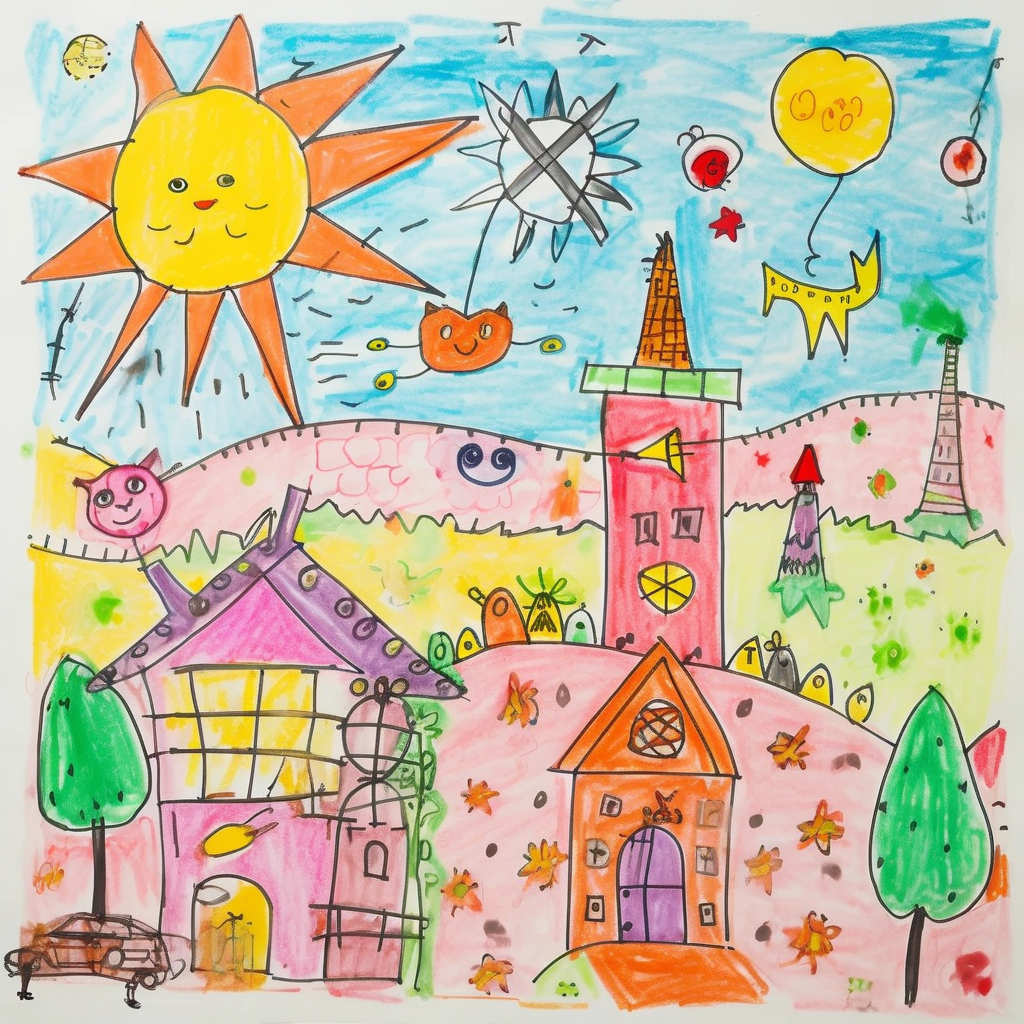
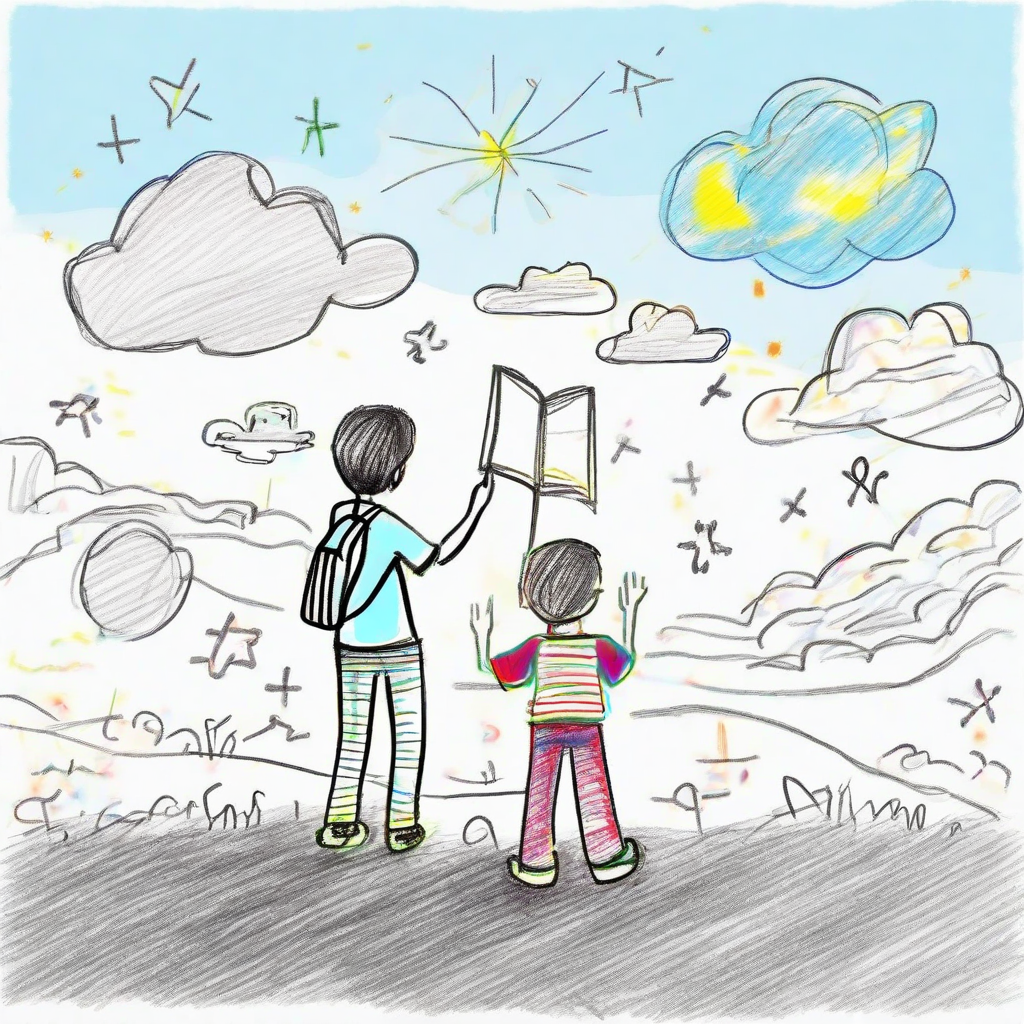

In [11]:
# Execute the Diffusion Inversion Process to map the reference image to its latent representation.
DDIM_inv_result = DDIM_Inversion_Process(Reference_Pipeline, ref_image, src_prompt, num_inference_steps, 2)

# Extract the latent representation from the Diffusion Inversion Result that can be used to guide the generation of new images in the desired style.
latent_vector_ref_img, inversion_callback = extract_latent_and_inversion(DDIM_inv_result, offset=5)

# Create a Random Number Generator on the CPU.
rand_gen = torch.Generator(device='cpu').manual_seed(10)
# Generate the images using the latent representation of the reference image as guidance.
latents = torch.randn(len(prompts), 4, 128, 128,                            # Random Latent Vectors shape
                      device='cpu',                                         # Latent Vectors on CPU.
                      generator=rand_gen,                                   # Random Number Generator.
                      dtype=Reference_Pipeline.unet.dtype,).to('cuda:0')    # Data Type of the Latent Vectors (same as required by the model's UNet).

# Set the first latent vector to the latent representation of the reference image extracted before.
latents[0] = latent_vector_ref_img

# Generate the images using the provided prompts and the latent vectors.
images_a = Reference_Pipeline(prompts,                                      # Prompts to generate images for.
                              latents=latents,                              # Latent Vectors to guide the generation of images.
                              callback_on_step_end=inversion_callback,      # Callback to update the latent vectors during the generation process.
                              num_inference_steps=num_inference_steps,      # Number of Inference Steps to generate the images.
                              guidance_scale=guidance_scale).images         # Guidance Scale to control the influence of the latent vectors on the generated images.

# Display the generated images.
handler.remove()
mediapy.show_images(images_a, titles=[p[:-(len(src_style) + 3)] for p in prompts])

100%|██████████| 50/50 [00:12<00:00,  3.93it/s]


  0%|          | 0/50 [00:00<?, ?it/s]


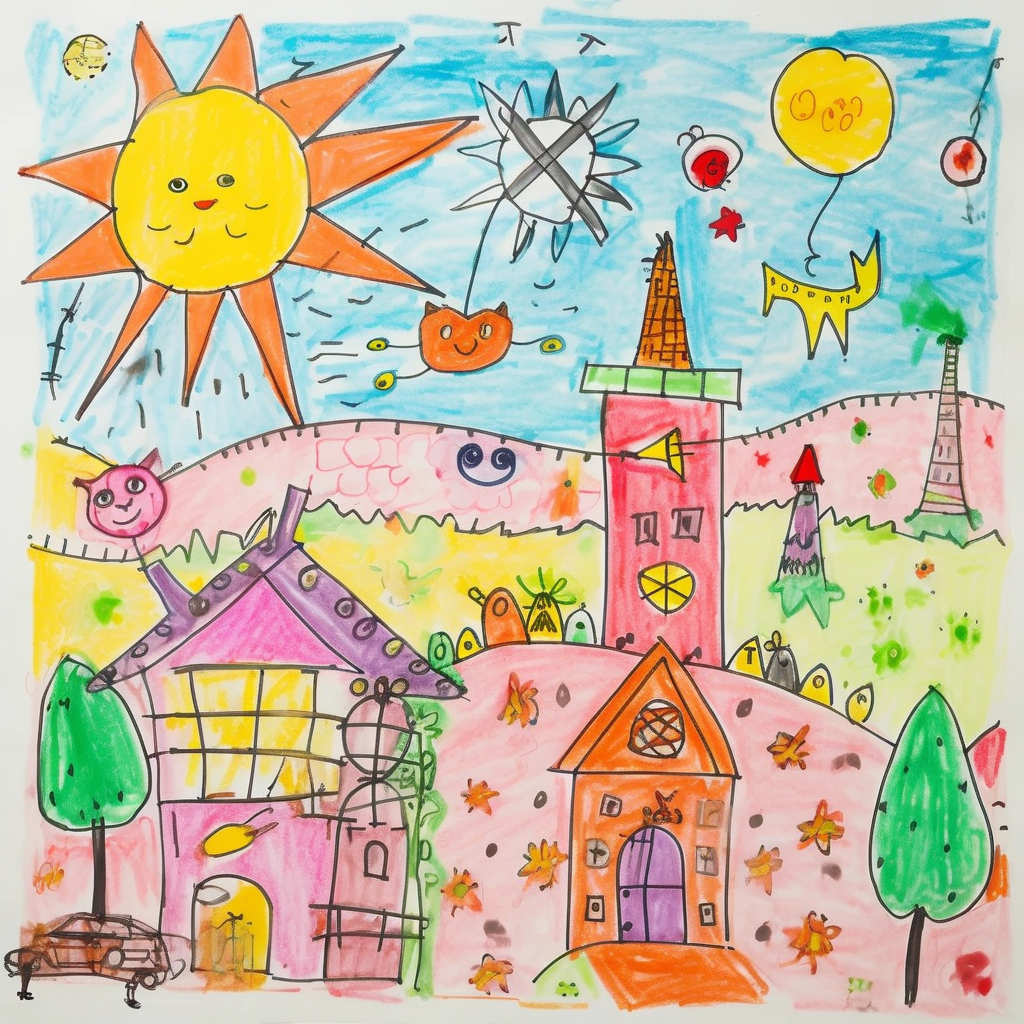
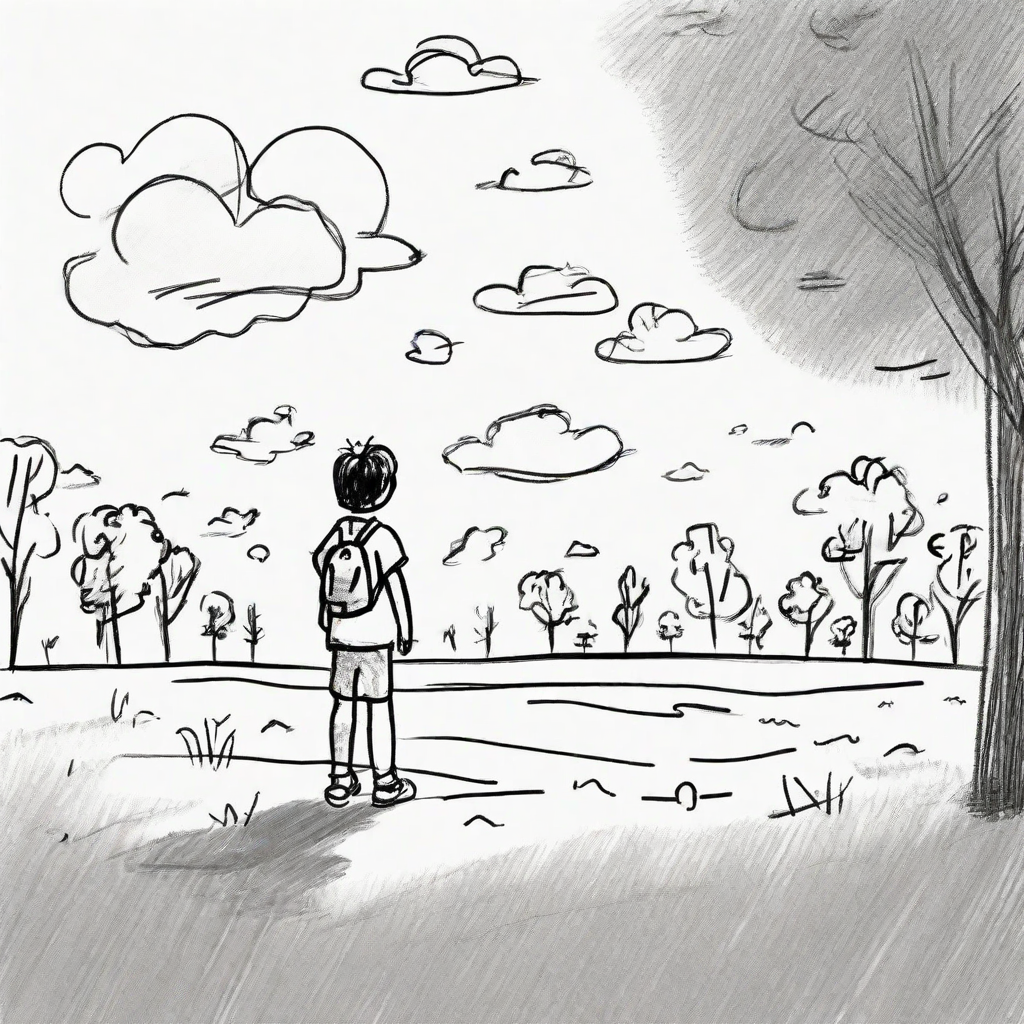

In [12]:
# Execute the Diffusion Inversion Process to map the reference image to its latent representation.
DDIM_inv_result = DDIM_Inversion_Process(Reference_Pipeline, ref_image, src_prompt, num_inference_steps, 2)

# Extract the latent representation from the Diffusion Inversion Result that can be used to guide the generation of new images in the desired style.
latent_vector_ref_img, inversion_callback = extract_latent_and_inversion(DDIM_inv_result, offset=5)

# Create a Random Number Generator on the CPU.
rand_gen = torch.Generator(device='cpu').manual_seed(10)
# Generate the images using the latent representation of the reference image as guidance.
latents = torch.randn(len(prompts), 4, 128, 128,                            # Random Latent Vectors shape
                      device='cpu',                                         # Latent Vectors on CPU.
                      generator=rand_gen,                                   # Random Number Generator.
                      dtype=Reference_Pipeline.unet.dtype,).to('cuda:0')    # Data Type of the Latent Vectors (same as required by the model's UNet).

# Set the first latent vector to the latent representation of the reference image extracted before.
latents[0] = latent_vector_ref_img

# Generate the images using the provided prompts and the latent vectors.
images_a = Reference_Pipeline(prompts,                                      # Prompts to generate images for.
                              latents=latents,                              # Latent Vectors to guide the generation of images.
                              callback_on_step_end=inversion_callback,      # Callback to update the latent vectors during the generation process.
                              num_inference_steps=num_inference_steps,      # Number of Inference Steps to generate the images.
                              guidance_scale=guidance_scale).images         # Guidance Scale to control the influence of the latent vectors on the generated images.

# Display the generated images.
handler.remove()
mediapy.show_images(images_a, titles=[p[:-(len(src_style) + 3)] for p in prompts])

In [1]:
# import tensorflow as tf
import torch

def clear_gpu_memory():
    # Clear TensorFlow GPU memory
    # tf.keras.backend.clear_session()
    # tf.compat.v1.reset_default_graph()

    # Clear PyTorch GPU memory
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    print("GPU memory cleared.")

# Execute the function to clear GPU memory
clear_gpu_memory()


GPU memory cleared.
